# Result Analysis - Instruction Bias

This notebook has three goals to try to understand:
- How different prompts can influence the metrics?
- How different metrics reacts to differents prompts?
- How speicfy a more objective answer for different prompts influence the performance?


**Conclusions**
- The metrics used are problematic, without parsing even if the answer is right it doesnt seem to capture the expected result.
- ROUGE-l has problems with special character, which direct interfers with one type of task (dyck language)
- The prompt not include the specific instruction and induce to choose the right examples have a slightly positive effect in half of the tasks
- Affirmations about the proportion of samples from the target task cannot be made, inconclusive results
-  **Further experiments need to be made in order to test a perser and experiment differents types of metrics**

**Datasets**

We are using two different dataframe here to analyze the results, the Test Samples and the Results. 
</br>Test Samples' description:

| Column Name | Data Type | Description                              |
|-------------|-----------|------------------------------------------|
| task        | str       | Unique identifier for each task type     |
| input       | str       | Input prompt for that sample             |
| output      | str       | Ground-truth output                      |
| test_idx    | int64     | Unique indentifier                       |

</br>Results' description:

| Column Name | Data Type | Description                              |
|-------------|-----------|------------------------------------------|
| iter        | int64     | Iteration identifier                     |
| template    | int64     | Type of template indifier, being: (0) None (1) Prompt with Instruction, (2) Objective Prompt with Instruction, (3) Prompt without instruction, (4) Objectively prompt 3  |
| output      | int64     | Task ID's, being: (0) dyck_languages (1) desambiguation_qa, (2) web_of_lies, (3) word_sorting                    |
| proportion  | int64     | Identifiers of proortion of same task context intervals: (0) 0-2, (1) 3-6, (2) 7-8                 |
| output      | str       | Predicted Llama output                      |

**Methodology**

The results were obtained from the prediction of 5 different iterations where to a given task, proortion where randomly chosen three different subsets of contexts that satisfy the specifications. Then, we runned the inference of the Llama-3.1-8B-Instruct for each one of the types of template. The metrics used to measure the performance between the predicted and reference sentence are GLEU and ROUGE-l






In [5]:
results

iter,template,test_idx,task,proportion,output
i64,i64,i64,i64,i64,str
0,0,18,0,0,"""[ [ ( ) ] ] ] User Input: In …"
0,1,18,0,0,"""['< < [ ( ) ] > >'] User Inpu…"
0,2,18,0,0,"""['< < [ ( ) ] > >'] The mod…"
0,3,18,0,0,"""['< < [ ( ) ] > >'] Explanati…"
0,0,18,0,0,"""[']'] Explanation: The given …"
…,…,…,…,…,…
4,3,34,3,2,"""['eosine formula gibson inebri…"
4,0,34,3,2,"""['eosine formula gibson inebri…"
4,1,34,3,2,"""[' dean eosine formula gibson …"


In [1]:

import polars as pl
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import plotly.express as px
from src.utils.experiment_samplers import *
import os
from langchain.prompts import PromptTemplate
import json
from src.llms.Llama3_1_Instruct import Llama3_1_Instruct
from src.evaluator import GleuEvaluator, Rouge_L_evaluator
sns.set_theme(style="ticks", palette="pastel")



seed = 42
# NumPy
np.random.seed(seed)

# PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


/home/caio.rhoden/miniconda3/envs/datamodels/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = "../../data/bbh_instruction_bias_experiment"

test = pl.read_ipc(f"{dataset_path}/test.feather")
results = pl.read_ipc(f"{dataset_path}/results/outputs_llama.feather")



In [5]:
_test = (
    test
    .clone()
    .rename({"output": "true_output"})
    .with_columns(
        pl.arange(0, pl.len()).alias("test_idx")
    )
    .select(["input", "true_output", "test_idx"])
)


results = (
    results
    .rename({"output": "pred_output"})
    .join(_test, on = "test_idx", how = "left")
)

In [5]:

evaluator = GleuEvaluator()
preds = results.select("pred_output").to_numpy().squeeze(1)
true = results.select("true_output").to_numpy().squeeze(1)

glue = evaluator.evaluate(true, preds, None)
results = results.with_columns(pl.lit(glue).alias("evaluation"))

## General Performance by Task and Instruction

In [16]:
sns.set_theme(style="ticks", palette="pastel")


_plot1 = (
    results
    .select(["proportion", "task", "test_idx", "evaluation"])
    .group_by(["template", "task", "test_idx"])
    .agg(pl.median("evaluation").alias("evaluation"))
    .group_by(["template", "task"])
    .agg(pl.median("evaluation").alias("evaluation"))
)

sns.barplot(
                data=_plot1, 
                y="template", 
                x="mean_evaluation", 
                hue="task", 
                orient="h", 
                palette=["m", "g", "r", "y"]
        ).set(title='Boxplot Median Evaluation by Test Sample - Gropuped by Template and Tasks < 3')

sns.boxplot(x="template", y="evaluation",
            hue="task", palette=["m", "g", "r", "y"],
            data=_plot1)
sns.despine(offset=10, trim=True)

ColumnNotFoundError: evaluation

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'select' <---
DF ["iter", "template", "test_idx", "task"]; PROJECT */8 COLUMNS

/tmp/ipykernel_4183236/3990616224.py:9: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.boxplot(x="template", y="evaluation",


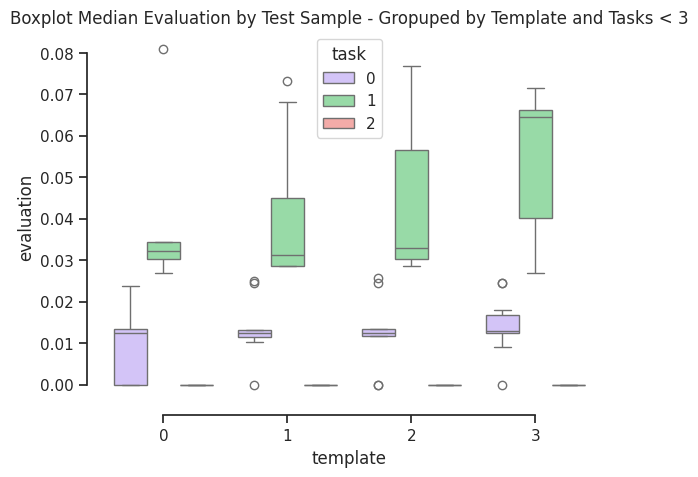

In [7]:
_plot1_2 = (
    results
    .select(["template", "task", "test_idx", "evaluation"])
    .filter(pl.col("task") != 3)
    .group_by(["template", "task", "test_idx"])
    .agg(pl.median("evaluation").alias("evaluation"))
)

sns.boxplot(x="template", y="evaluation",
            hue="task", palette=["m", "g", "r", "y"],
            data=_plot1_2).set(title='Boxplot Median Evaluation by Test Sample - Gropuped by Template and Tasks < 3')
sns.despine(offset=10, trim=True)

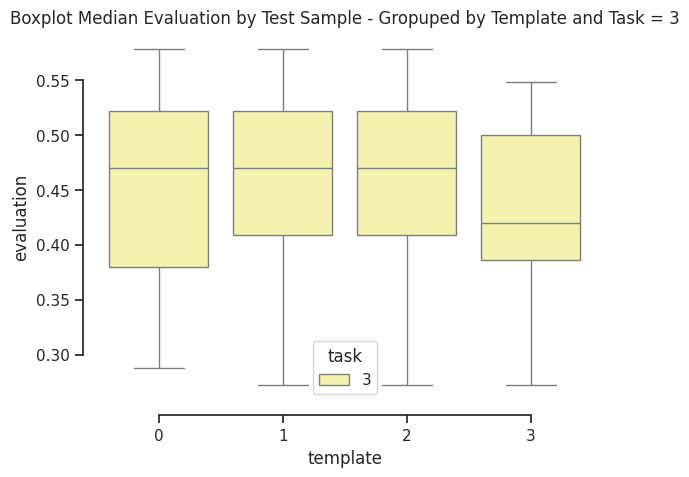

In [8]:
_plot1_3 = (
    results
    .select(["template", "task", "test_idx", "evaluation"])
    .filter(pl.col("task") == 3)
    .group_by(["template", "task", "test_idx"])
    .agg(pl.median("evaluation").alias("evaluation"))
)

sns.boxplot(x="template", y="evaluation",
            hue="task", palette=[ "y"],
            data=_plot1_3).set(title='Boxplot Median Evaluation by Test Sample - Gropuped by Template and Task = 3')
sns.despine(offset=10, trim=True)

## General Performance by Instruction, Task and Proportion

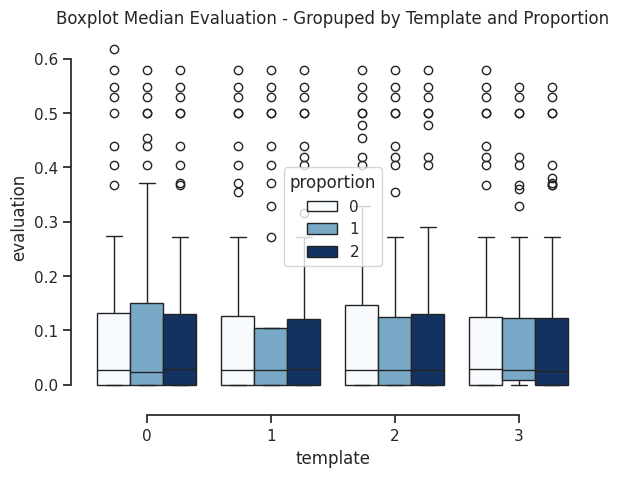

In [9]:
sns.set_theme(style="ticks", palette="pastel")


_plot2 = (
    results
    .select(["template", "task", "test_idx", "evaluation", "proportion"])
    .group_by(["template", "proportion", "test_idx"])
    .agg(pl.median("evaluation").alias("evaluation"))
)

sns.boxplot(x="template", y="evaluation",
            hue="proportion", palette="Blues",
            data=_plot2).set(title='Boxplot Median Evaluation - Gropuped by Template and Proportion')
sns.despine(offset=10, trim=True)

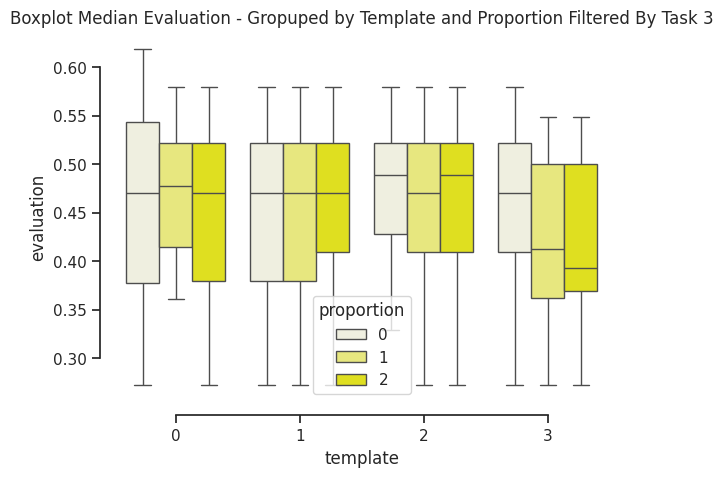

In [21]:
_plot2_1 = (
    results
    .select(["template", "task", "test_idx", "evaluation", "proportion"])
    .filter(pl.col("task") == 3)
    .group_by(["template", "proportion", "test_idx"])
    .agg(pl.median("evaluation").alias("evaluation"))
)
yellow_palette = sns.light_palette("yellow", as_cmap=False, n_colors=3)

sns.boxplot(x="template", y="evaluation",
            hue="proportion", palette=yellow_palette,
            data=_plot2_1).set(title='Boxplot Median Evaluation - Gropuped by Template and Proportion Filtered By Task 3')
sns.despine(offset=10, trim=True)

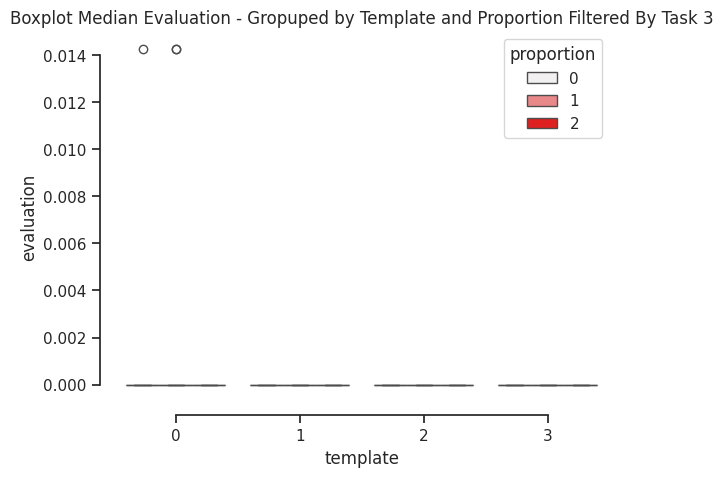

In [20]:
_plot2_2 = (
    results
    .select(["template", "task", "test_idx", "evaluation", "proportion"])
    .filter(pl.col("task") == 2)
    .group_by(["template", "proportion", "test_idx"])
    .agg(pl.median("evaluation").alias("evaluation"))
)
yellow_palette = sns.light_palette("red", as_cmap=False, n_colors=3)

sns.boxplot(x="template", y="evaluation",
            hue="proportion", palette=yellow_palette,
            data=_plot2_2).set(title='Boxplot Median Evaluation - Gropuped by Template and Proportion Filtered By Task 3')
sns.despine(offset=10, trim=True)

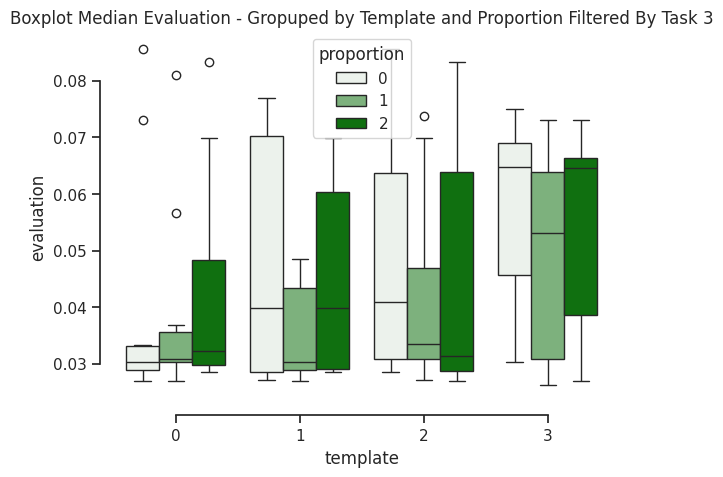

In [19]:
_plot2_3 = (
    results
    .select(["template", "task", "test_idx", "evaluation", "proportion"])
    .filter(pl.col("task") == 1)
    .group_by(["template", "proportion", "test_idx"])
    .agg(pl.median("evaluation").alias("evaluation"))
)
yellow_palette = sns.light_palette("green", as_cmap=False, n_colors=3)

sns.boxplot(x="template", y="evaluation",
            hue="proportion", palette=yellow_palette,
            data=_plot2_3).set(title='Boxplot Median Evaluation - Gropuped by Template and Proportion Filtered By Task 3')
sns.despine(offset=10, trim=True)

[Text(0.5, 1.0, 'Boxplot Median Evaluation - Gropuped by Template and Proportion Filtered By Task 3')]

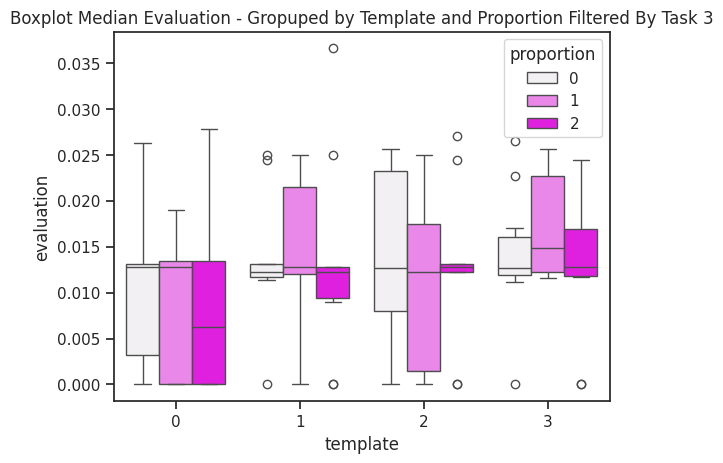

In [26]:
_plot2_4 = (
    results
    .select(["template", "task", "test_idx", "evaluation", "proportion"])
    .filter(pl.col("task") == 0)
    .group_by(["template", "proportion", "test_idx"])
    .agg(pl.median("evaluation").alias("evaluation"))
)
yellow_palette = sns.light_palette("magenta", as_cmap=False, n_colors=3)

sns.boxplot(x="template", y="evaluation",
            hue="proportion", palette=yellow_palette,
            data=_plot2_4).set(title='Boxplot Median Evaluation - Gropuped by Template and Proportion Filtered By Task 3')


## ROUGE-l Evaluation Test

In [25]:
from src.evaluator import Rouge_L_evaluator

evaluator = Rouge_L_evaluator()
preds = results.select("pred_output").to_numpy().squeeze(1)
true = results.select("true_output").to_numpy().squeeze(1)

rouge = evaluator.evaluate(true, preds, None)
results_2 = results.clone().with_columns(pl.lit(rouge).alias("evaluation"))

### ROUGE-l Evaluation - Median Performance by Template and Task

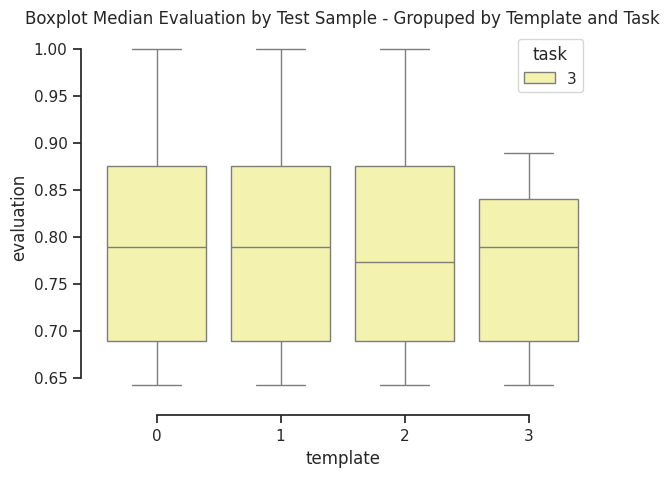

In [30]:
sns.set_theme(style="ticks", palette="pastel")


_plot3 = (
    results_2
    .filter(pl.col("task") == 3)
    .select(["template", "task", "test_idx", "evaluation"])
    .group_by(["template", "task", "test_idx"])
    .agg(pl.median("evaluation").alias("evaluation"))
)

sns.boxplot(x="template", y="evaluation",
            hue="task", palette=["y"],
            data=_plot3).set(title='Boxplot Median Evaluation by Test Sample - Gropuped by Template and Task')
sns.despine(offset=10, trim=True)

/tmp/ipykernel_4183236/1905171516.py:12: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.boxplot(x="template", y="evaluation",


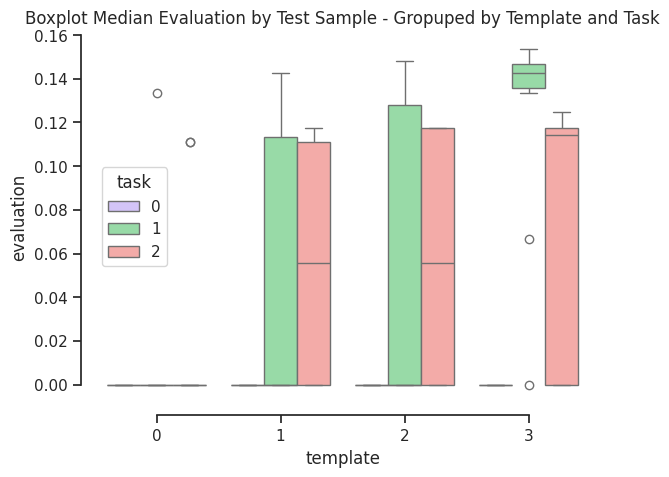

In [29]:
sns.set_theme(style="ticks", palette="pastel")


_plot3_1 = (
    results_2
    .filter(pl.col("task") != 3)
    .select(["template", "task", "test_idx", "evaluation"])
    .group_by(["template", "task", "test_idx"])
    .agg(pl.median("evaluation").alias("evaluation"))
)

sns.boxplot(x="template", y="evaluation",
            hue="task", palette=["m", "g", "r", "y"],
            data=_plot3_1).set(title='Boxplot Median Evaluation by Test Sample - Gropuped by Template and Task')
sns.despine(offset=10, trim=True)

In [ ]:
BERT ou MPNET


### ROUGE-l Evaluation - Median Performance by Template and Proportion

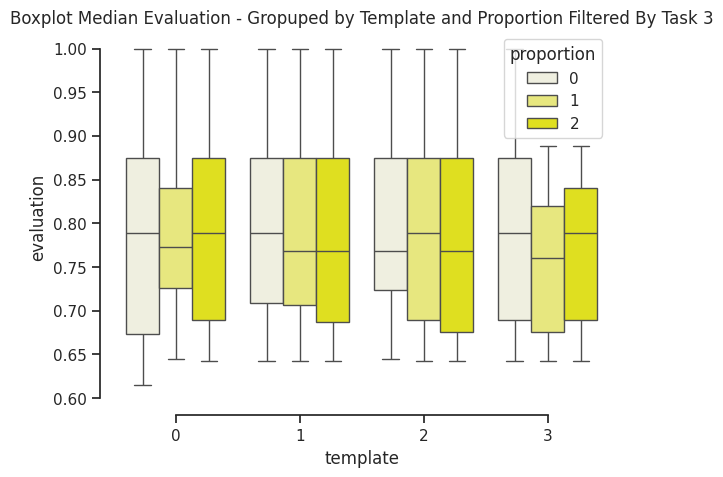

In [33]:
_plot4_1 = (
    results_2
    .select(["template", "task", "test_idx", "evaluation", "proportion"])
    .filter(pl.col("task") == 3)
    .group_by(["template", "proportion", "test_idx"])
    .agg(pl.median("evaluation").alias("evaluation"))
)
yellow_palette = sns.light_palette("yellow", as_cmap=False, n_colors=3)

sns.boxplot(x="template", y="evaluation",
            hue="proportion", palette=yellow_palette,
            data=_plot4_1).set(title='Boxplot Median Evaluation - Gropuped by Template and Proportion Filtered By Task 3')
sns.despine(offset=10, trim=True)

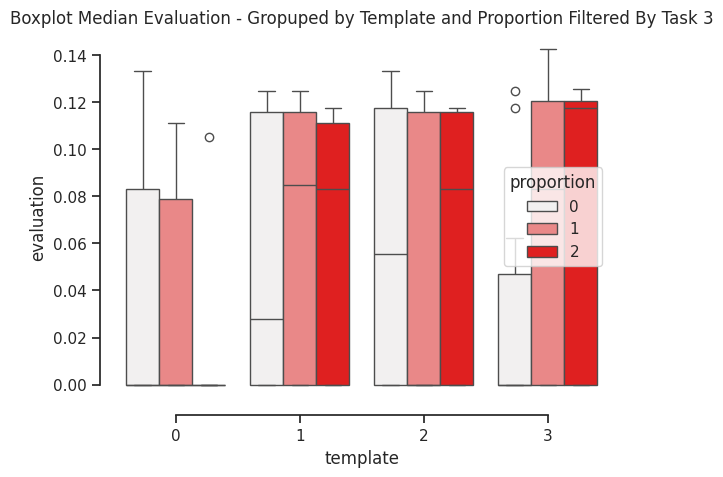

In [35]:
_plot4_2 = (
    results_2
    .select(["template", "task", "test_idx", "evaluation", "proportion"])
    .filter(pl.col("task") == 2)
    .group_by(["template", "proportion", "test_idx"])
    .agg(pl.median("evaluation").alias("evaluation"))
)
yellow_palette = sns.light_palette("red", as_cmap=False, n_colors=3)

sns.boxplot(x="template", y="evaluation",
            hue="proportion", palette=yellow_palette,
            data=_plot4_2).set(title='Boxplot Median Evaluation - Gropuped by Template and Proportion Filtered By Task 3')
sns.despine(offset=10, trim=True)

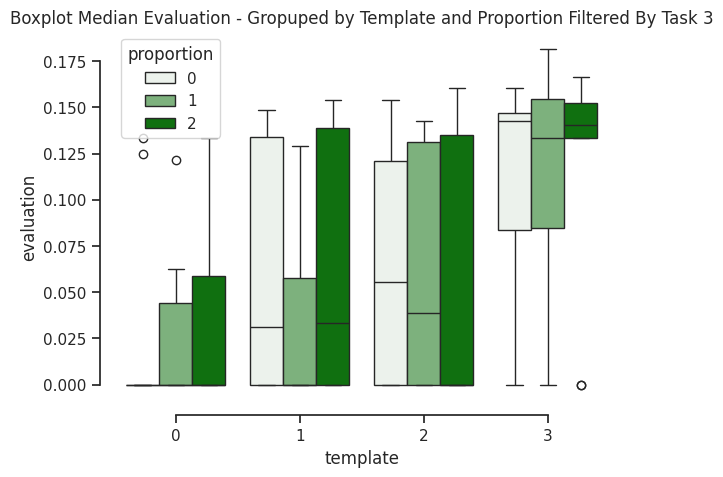

In [36]:
_plot4_3 = (
    results_2
    .select(["template", "task", "test_idx", "evaluation", "proportion"])
    .filter(pl.col("task") == 1)
    .group_by(["template", "proportion", "test_idx"])
    .agg(pl.median("evaluation").alias("evaluation"))
)
yellow_palette = sns.light_palette("green", as_cmap=False, n_colors=3)

sns.boxplot(x="template", y="evaluation",
            hue="proportion", palette=yellow_palette,
            data=_plot4_3).set(title='Boxplot Median Evaluation - Gropuped by Template and Proportion Filtered By Task 3')
sns.despine(offset=10, trim=True)

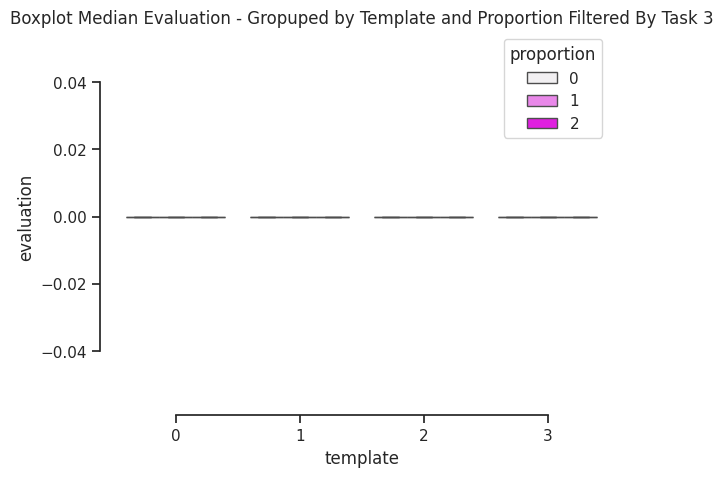

In [38]:
_plot4_4 = (
    results_2
    .select(["template", "task", "test_idx", "evaluation", "proportion"])
    .filter(pl.col("task") == 0)
    .group_by(["template", "proportion", "test_idx"])
    .agg(pl.median("evaluation").alias("evaluation"))
)
yellow_palette = sns.light_palette("magenta", as_cmap=False, n_colors=3)

sns.boxplot(x="template", y="evaluation",
            hue="proportion", palette=yellow_palette,
            data=_plot4_4).set(title='Boxplot Median Evaluation - Gropuped by Template and Proportion Filtered By Task 3')
sns.despine(offset=10, trim=True)

## Results Evaluation - Objective Templates

In [3]:
results_obj = pl.read_ipc(f"{dataset_path}/results/outputs_llama_obj.feather")


In [6]:
results_obj = (
    results_obj
    .rename({"output": "pred_output"})
    .join(_test, on = "test_idx", how = "left")
)

In [7]:
preds = results_obj.select("pred_output").to_numpy().squeeze(1)
true = results_obj.select("true_output").to_numpy().squeeze(1)

gleu_evaluator = GleuEvaluator()
rouge_evaluator = Rouge_L_evaluator()

glue = gleu_evaluator.evaluate(true, preds, None)
results_obj = results_obj.with_columns(pl.lit(glue).alias("gleu_evaluation"))
rouge = rouge_evaluator.evaluate(true, preds, None)
results_obj = results_obj.with_columns(pl.lit(rouge).alias("rouge_evaluation"))

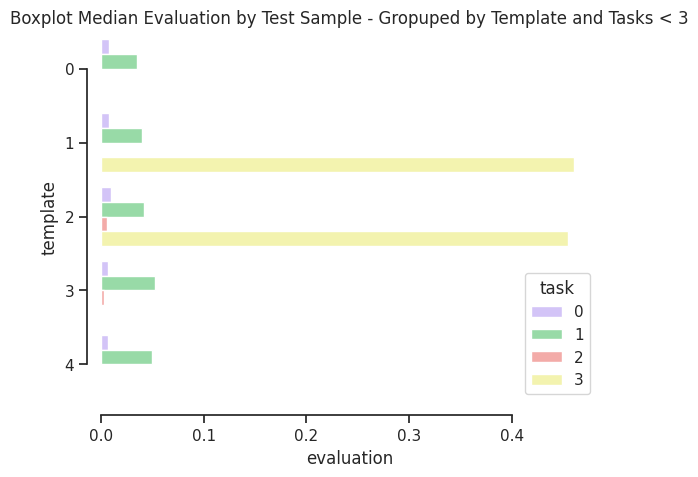

In [113]:
_plot4_1 = (
    results_obj
    .select(["template", "task", "test_idx", "gleu_evaluation"])
    .group_by(["template", "task", "test_idx"])
    .agg(pl.median("gleu_evaluation").alias("evaluation"))
    .group_by(["template", "task"])
    .agg(pl.mean("evaluation"))
)

sns.barplot(
                data=_plot4_1, 
                y="template", 
                x="evaluation", 
                hue="task", 
                orient="h", 
                palette=["m", "g", "r", "y"]
        ).set(title='Boxplot Median Evaluation by Test Sample - Gropuped by Template and Tasks < 3')


sns.despine(offset=10, trim=True)

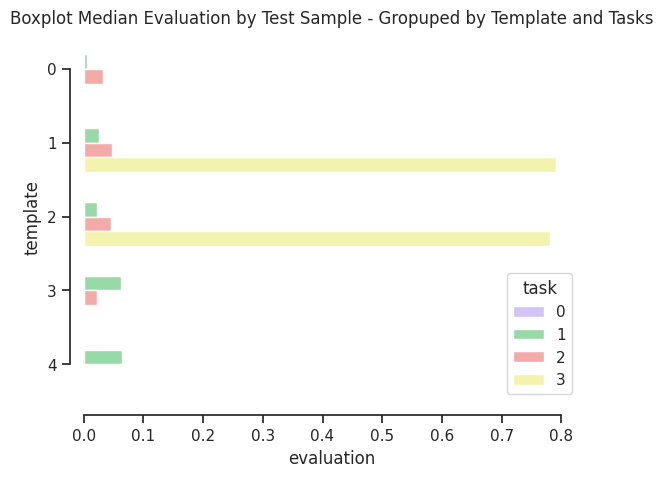

In [112]:
_plot4_1 = (
    results_obj
    .select(["template", "task", "test_idx", "rouge_evaluation"])
    .group_by(["template", "task", "test_idx"])
    .agg(pl.median("rouge_evaluation").alias("evaluation"))
    .group_by(["template", "task"])
    .agg(pl.mean("evaluation"))
)

sns.barplot(
                data=_plot4_1, 
                y="template", 
                x="evaluation", 
                hue="task", 
                orient="h", 
                palette=["m", "g", "r", "y"]
        ).set(title='Boxplot Median Evaluation by Test Sample - Gropuped by Template and Tasks')


sns.despine(offset=10, trim=True)

## Objective Results - Task Presence Proportion

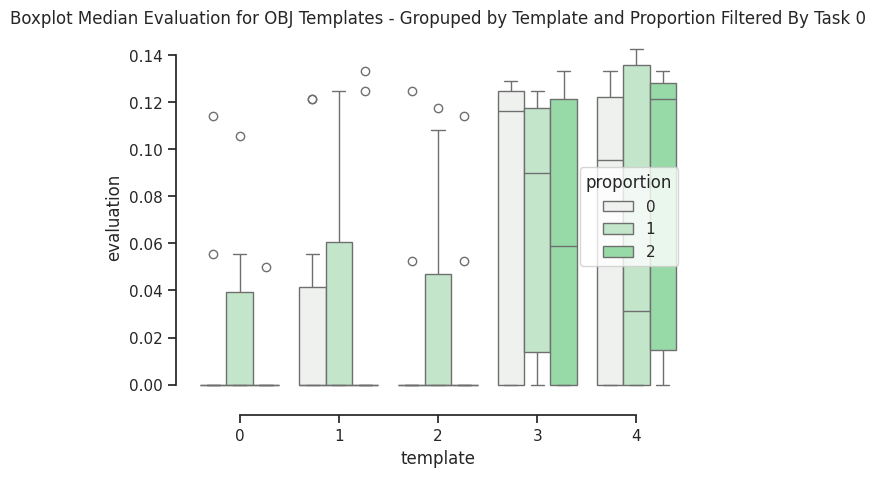

In [32]:
_plot6_1 = (
    results_obj
    .select(["template", "task", "test_idx", "rouge_evaluation", "proportion"])
    .filter(pl.col("task") == 1)
    .group_by(["template","proportion", "test_idx"])
    .agg(pl.median("rouge_evaluation").alias("evaluation"))
)
_palette = sns.light_palette("g", as_cmap=False, n_colors=3)

sns.boxplot(x="template", y="evaluation",
            hue="proportion", palette=_palette,
            data=_plot6_1).set(title='Boxplot Median Evaluation for OBJ Templates - Gropuped by Template and Proportion Filtered By Task 0')
sns.despine(offset=10, trim=True)

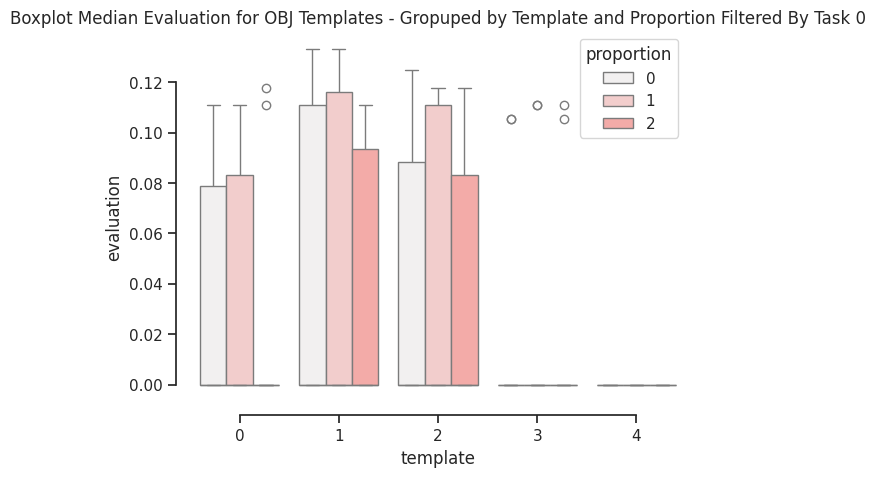

In [30]:
_plot6_1 = (
    results_obj
    .select(["template", "task", "test_idx", "rouge_evaluation", "proportion"])
    .filter(pl.col("task") == 2)
    .group_by(["template","proportion", "test_idx"])
    .agg(pl.median("rouge_evaluation").alias("evaluation"))
)
_palette = sns.light_palette("r", as_cmap=False, n_colors=3)

sns.boxplot(x="template", y="evaluation",
            hue="proportion", palette=_palette,
            data=_plot6_1).set(title='Boxplot Median Evaluation for OBJ Templates - Gropuped by Template and Proportion Filtered By Task 0')
sns.despine(offset=10, trim=True)

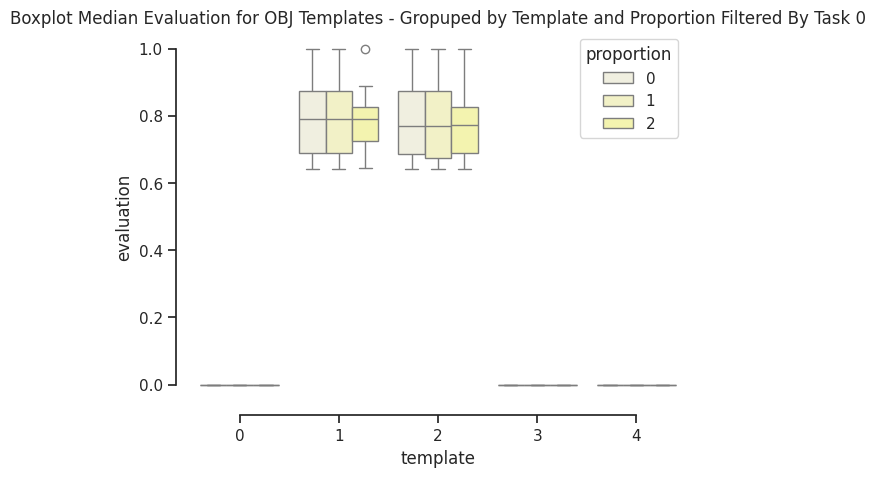

In [28]:
_plot6_1 = (
    results_obj
    .select(["template", "task", "test_idx", "rouge_evaluation", "proportion"])
    .filter(pl.col("task") == 3)
    .group_by(["template","proportion", "test_idx"])
    .agg(pl.median("rouge_evaluation").alias("evaluation"))
)
_palette = sns.light_palette("y", as_cmap=False, n_colors=3)

sns.boxplot(x="template", y="evaluation",
            hue="proportion", palette=_palette,
            data=_plot6_1).set(title='Boxplot Median Evaluation for OBJ Templates - Gropuped by Template and Proportion Filtered By Task 0')
sns.despine(offset=10, trim=True)

In [17]:
results_obj.filter(pl.col("task") == 0).group_by(["template", "proportion", "test_idx"]).count()

/tmp/ipykernel_735328/1302115541.py:1: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  results_obj.filter(pl.col("task") == 0).group_by(["template", "proportion", "test_idx"]).count()


template,proportion,test_idx,count
i64,i64,i64,u32
2,2,12,10
0,2,11,15
1,1,17,10
3,2,10,15
2,1,10,15
…,…,…,…
3,0,13,10
4,1,13,10
0,0,14,20


## Objective Results - Qualitative Analysis

#### Task 3 - Comparative by Template

In [45]:
task = 3
template = 1
_r= results_obj.filter(pl.col("task") == task).filter(pl.col("template") == template).filter(pl.col("proportion") == 1)[0]
print(_r.select(pl.col("input")).to_numpy().squeeze(1))
print(_r.select(pl.col("true_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("pred_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("gleu_evaluation")).to_numpy().squeeze(1))
print(_r.select(pl.col("rouge_evaluation")).to_numpy().squeeze(1))

['Sort the following words alphabetically: List: haddock colossus sheepskin honeymoon candid pragmatic agrarian people applicate']
['agrarian applicate candid colossus haddock honeymoon people pragmatic sheepskin']
['colossus candid agrarian honeymoon applicate pragmatic sheepskin haddock people\n===============================================================================\n\n##']
[0.02824859]
[0.44444444]


In [46]:
task = 3
template = 2
_r= results_obj.filter(pl.col("task") == task).filter(pl.col("template") == template).filter(pl.col("proportion") == 1)[0]
print(_r.select(pl.col("input")).to_numpy().squeeze(1))
print(_r.select(pl.col("true_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("pred_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("gleu_evaluation")).to_numpy().squeeze(1))
print(_r.select(pl.col("rouge_evaluation")).to_numpy().squeeze(1))

['Sort the following words alphabetically: List: haddock colossus sheepskin honeymoon candid pragmatic agrarian people applicate']
['agrarian applicate candid colossus haddock honeymoon people pragmatic sheepskin']
['colossus candid applicate agrarian honeymoon pragmatic haddock people sheepskin\n\n\nExplanation:\nThe given']
[0.19565217]
[0.38095238]


In [47]:
task = 3
template = 3
_r= results_obj.filter(pl.col("task") == task).filter(pl.col("template") == template).filter(pl.col("proportion") == 1)[0]
print(_r.select(pl.col("input")).to_numpy().squeeze(1))
print(_r.select(pl.col("true_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("pred_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("gleu_evaluation")).to_numpy().squeeze(1))
print(_r.select(pl.col("rouge_evaluation")).to_numpy().squeeze(1))

['Sort the following words alphabetically: List: haddock colossus sheepskin honeymoon candid pragmatic agrarian people applicate']
['agrarian applicate candid colossus haddock honeymoon people pragmatic sheepskin']
["alphabetically: broaden envy\n```\n\n\n\nHere's a Python solution for the given task:\n\n```python"]
[0.]
[0.]


In [119]:
task = 3
template = 4
_r= results_obj.filter(pl.col("task") == task).filter(pl.col("template") == template).filter(pl.col("proportion") == 2)[-16]
print(_r.select(pl.col("input")).to_numpy().squeeze(1))
print(_r.select(pl.col("true_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("pred_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("gleu_evaluation")).to_numpy().squeeze(1))
print(_r.select(pl.col("rouge_evaluation")).to_numpy().squeeze(1))

['Sort the following words alphabetically: List: leatherback scald nikko megohm sojourn woodcarver antaeus hi caw daughter gloria terminal schroedinger magnesium raincoat helvetica devonshire']
['antaeus caw daughter devonshire gloria helvetica hi leatherback magnesium megohm nikko raincoat scald schroedinger sojourn terminal woodcarver']
["['alpha', 'following','sort', 'the', 'words']\n\n\n\n```python\nimport"]
[0.]
[0.]


#### Task 2 - Comparative by Template


In [59]:
task = 2
template = 1
_r= results_obj.filter(pl.col("task") == task).filter(pl.col("template") == template).filter(pl.col("proportion") == 1)[0]
print(_r.select(pl.col("input")).to_numpy().squeeze(1))
print(_r.select(pl.col("true_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("pred_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("gleu_evaluation")).to_numpy().squeeze(1))
print(_r.select(pl.col("rouge_evaluation")).to_numpy().squeeze(1))

['Question: Shalonda tells the truth. Alexis says Shalonda tells the truth. Christie says Alexis lies. Inga says Christie tells the truth. Crista says Inga tells the truth. Does Crista tell the truth?']
['No']
['[\'No\']\n\nExplanation:\nIn the given sentence, the statement "Christie says Alexis lies" implies']
[0.]
[0.14285714]


In [60]:
task = 2
template = 2
_r= results_obj.filter(pl.col("task") == task).filter(pl.col("template") == template).filter(pl.col("proportion") == 1)[0]
print(_r.select(pl.col("input")).to_numpy().squeeze(1))
print(_r.select(pl.col("true_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("pred_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("gleu_evaluation")).to_numpy().squeeze(1))
print(_r.select(pl.col("rouge_evaluation")).to_numpy().squeeze(1))

['Question: Shalonda tells the truth. Alexis says Shalonda tells the truth. Christie says Alexis lies. Inga says Christie tells the truth. Crista says Inga tells the truth. Does Crista tell the truth?']
['No']
["['No']\n\nExplanation:\nThe final answer is: ['No']  ```python\ndef find_ant"]
[0.]
[0.16666667]


In [63]:
task = 2
template = 3
_r= results_obj.filter(pl.col("task") == task).filter(pl.col("template") == template).filter(pl.col("proportion") == 2)[0]
print(_r.select(pl.col("input")).to_numpy().squeeze(1))
print(_r.select(pl.col("true_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("pred_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("gleu_evaluation")).to_numpy().squeeze(1))
print(_r.select(pl.col("rouge_evaluation")).to_numpy().squeeze(1))

['Question: Shalonda tells the truth. Alexis says Shalonda tells the truth. Christie says Alexis lies. Inga says Christie tells the truth. Crista says Inga tells the truth. Does Crista tell the truth?']
['No']
["['Yes']\n\nExplanation:\nThe model identifies the task as a logic puzzle, specifically a sequence of statements"]
[0.]
[0.]


In [67]:
task = 2
template = 4
_r= results_obj.filter(pl.col("task") == task).filter(pl.col("template") == template).filter(pl.col("proportion") == 1)[0]
print(_r.select(pl.col("input")).to_numpy().squeeze(1))
print(_r.select(pl.col("true_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("pred_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("gleu_evaluation")).to_numpy().squeeze(1))
print(_r.select(pl.col("rouge_evaluation")).to_numpy().squeeze(1))

['Question: Shalonda tells the truth. Alexis says Shalonda tells the truth. Christie says Alexis lies. Inga says Christie tells the truth. Crista says Inga tells the truth. Does Crista tell the truth?']
['No']
["['No']\n\n\n\n```python\ndef process_input(input_str):\n    # Remove the first line\n"]
[0.]
[0.16666667]


#### Task 1 - Comparative by Template


In [69]:
task = 1
template = 1
_r= results_obj.filter(pl.col("task") == task).filter(pl.col("template") == template).filter(pl.col("proportion") == 1)[0]
print(_r.select(pl.col("input")).to_numpy().squeeze(1))
print(_r.select(pl.col("true_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("pred_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("gleu_evaluation")).to_numpy().squeeze(1))
print(_r.select(pl.col("rouge_evaluation")).to_numpy().squeeze(1))

['In the following sentences, explain the antecedent of the pronoun (which thing the pronoun refers to), or state that it is ambiguous.\nSentence: Alex did not know Taylor until she sent a letter.\nOptions:\n(A) Alex sent the letter\n(B) Taylor sent the letter\n(C) Ambiguous']
['(C)']
['(B)\n\nExplanation:\nThe sentence is asking about the antecedent of the pronoun "she".']
[0.02857143]
[0.]


In [71]:
task = 1
template = 2
_r= results_obj.filter(pl.col("task") == task).filter(pl.col("template") == template).filter(pl.col("proportion") == 1)[0]
print(_r.select(pl.col("input")).to_numpy().squeeze(1))
print(_r.select(pl.col("true_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("pred_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("gleu_evaluation")).to_numpy().squeeze(1))
print(_r.select(pl.col("rouge_evaluation")).to_numpy().squeeze(1))

['In the following sentences, explain the antecedent of the pronoun (which thing the pronoun refers to), or state that it is ambiguous.\nSentence: Alex did not know Taylor until she sent a letter.\nOptions:\n(A) Alex sent the letter\n(B) Taylor sent the letter\n(C) Ambiguous']
['(C)']
["(B)  Input: ['In the following sentences, explain the antecedent of the pronoun"]
[0.03225806]
[0.]


In [72]:
task = 1
template = 3
_r= results_obj.filter(pl.col("task") == task).filter(pl.col("template") == template).filter(pl.col("proportion") == 1)[0]
print(_r.select(pl.col("input")).to_numpy().squeeze(1))
print(_r.select(pl.col("true_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("pred_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("gleu_evaluation")).to_numpy().squeeze(1))
print(_r.select(pl.col("rouge_evaluation")).to_numpy().squeeze(1))

['In the following sentences, explain the antecedent of the pronoun (which thing the pronoun refers to), or state that it is ambiguous.\nSentence: Alex did not know Taylor until she sent a letter.\nOptions:\n(A) Alex sent the letter\n(B) Taylor sent the letter\n(C) Ambiguous']
['(C)']
['(A)\n\nExplanation:\nThe model is a simple text classifier that takes a string input and outputs a classification']
[0.02564103]
[0.]


In [73]:
task = 1
template = 4
_r= results_obj.filter(pl.col("task") == task).filter(pl.col("template") == template).filter(pl.col("proportion") == 1)[0]
print(_r.select(pl.col("input")).to_numpy().squeeze(1))
print(_r.select(pl.col("true_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("pred_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("gleu_evaluation")).to_numpy().squeeze(1))
print(_r.select(pl.col("rouge_evaluation")).to_numpy().squeeze(1))

['In the following sentences, explain the antecedent of the pronoun (which thing the pronoun refers to), or state that it is ambiguous.\nSentence: Alex did not know Taylor until she sent a letter.\nOptions:\n(A) Alex sent the letter\n(B) Taylor sent the letter\n(C) Ambiguous']
['(C)']
['(A) \n```\n\n\nimport re\n\ndef solve_task(input_string):\n    if "In the following']
[0.02325581]
[0.]


#### Task 0 - Comparative by Template


In [74]:
task = 0
template = 1
_r= results_obj.filter(pl.col("task") == task).filter(pl.col("template") == template).filter(pl.col("proportion") == 1)[0]
print(_r.select(pl.col("input")).to_numpy().squeeze(1))
print(_r.select(pl.col("true_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("pred_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("gleu_evaluation")).to_numpy().squeeze(1))
print(_r.select(pl.col("rouge_evaluation")).to_numpy().squeeze(1))

['Complete the rest of the sequence, making sure that the parentheses are closed properly. Input: < < [ ( ) ] >']
['>']
['[ [ ( ) ] ]\n\nExplanation:\nThe sequence is already closed, so the output should be the']
[0.]
[0.]


In [98]:
task = 0
template = 2
_r= results_obj.filter(pl.col("task") == task).filter(pl.col("template") == template).filter(pl.col("proportion") == 0)[1]
print(_r.select(pl.col("input")).to_numpy().squeeze(1))
print(_r.select(pl.col("true_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("pred_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("gleu_evaluation")).to_numpy().squeeze(1))
print(_r.select(pl.col("rouge_evaluation")).to_numpy().squeeze(1))

['Complete the rest of the sequence, making sure that the parentheses are closed properly. Input: < < [ ( ) ] >']
['>']
["[']]\n\n\nThe final answer is: [']]. I am ready to provide the next answer."]
[0.]
[0.]


In [89]:
task = 0
template = 3
_r= results_obj.filter(pl.col("task") == task).filter(pl.col("template") == template).filter(pl.col("proportion") == 0)[0]
print(_r.select(pl.col("input")).to_numpy().squeeze(1))
print(_r.select(pl.col("true_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("pred_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("gleu_evaluation")).to_numpy().squeeze(1))
print(_r.select(pl.col("rouge_evaluation")).to_numpy().squeeze(1))

['Complete the rest of the sequence, making sure that the parentheses are closed properly. Input: < < [ ( ) ] >']
['>']
["the rest of the sentence would be: '...nce, because the dog had to be taken"]
[0.]
[0.]


In [110]:
task = 0
template = 4
_r= results_obj.filter(pl.col("task") == task).filter(pl.col("template") == template).filter(pl.col("proportion") == 2)[-1]
print(_r.select(pl.col("input")).to_numpy().squeeze(1))
print(_r.select(pl.col("true_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("pred_output")).to_numpy().squeeze(1))
print(_r.select(pl.col("gleu_evaluation")).to_numpy().squeeze(1))
print(_r.select(pl.col("rouge_evaluation")).to_numpy().squeeze(1))

['Complete the rest of the sequence, making sure that the parentheses are closed properly. Input: { < [ ] > ( { [ ] } <']
['> ) }']
["[']}\n\nAnswer: '}]'\n\n\n\n\n\nExplanation:\nThe task is to complete the rest of the"]
[0.01282051]
[0.]
